In [203]:
%matplotlib inline
import pickle
import urllib
import time
import feedparser
import itertools
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [261]:
def create_graph_adj_list(data, authors, adj_list=set(), weighted_adj_list=None):
    all_author_pairs = [(min(a1, a2), max(a1, a2)) for (a1, a2) in itertools.combinations(authors, 2)]
    all_author_pairs_set = set(all_author_pairs)
    if weighted_adj_list is None:
        weighted_adj_list = {}
        for pair in all_author_pairs:
            weighted_adj_list[pair] = 0
    
    for entry in data:
        paper_authors = entry[2]
        author_pairs = [(min(a1, a2), max(a1, a2)) for (a1, a2) in itertools.combinations(paper_authors, 2)]
        for ap in author_pairs:
            if ap[0] in authors and ap[1] in authors:
                if ap in all_author_pairs_set:
                    adj_list.add(ap)
                    weighted_adj_list[ap] += 1
                
    return adj_list, weighted_adj_list

In [ ]:
"""
Adapted from http://export.arxiv.org/api_help/docs/user-manual.html
"""

# Base api query url
base_url = 'http://export.arxiv.org/api/query?';

# Search parameters
category = 'astro-ph'
search_query = 'cat:' + category # search for electron in all fields
start = 0                        # start at the first result
total_results = 30000            # want 20 total results
results_per_iteration = 2000     # 5 results at a time
wait_time = 3                    # number of seconds to wait beetween calls

print 'Searching arXiv for %s' % search_query

entries = []

with open(category + ".txt", "w") as f:

    for i in range(start,total_results,results_per_iteration):
        print "Results %i - %i" % (i,i+results_per_iteration)
        query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                             i,
                                                            results_per_iteration)
        # perform a GET request using the base_url and query
        response = urllib.urlopen(base_url+query).read()

        # parse the response using feedparser
        feed = feedparser.parse(response)

        # Run through each entry, and print out information
        for entry in feed.entries:
            title = entry.title.encode('utf-8').replace("\n", "")
            year = entry.published_parsed[0]
            authors = tuple([str(author['name'].encode('utf-8')) for author in entry.authors])
            entries.append((title, year, authors))

            f.write(title + "," + str(year) + "," + "|".join(authors) + "\n")

        print 'Sleeping for %i seconds' % wait_time 
        time.sleep(wait_time)

# pickle.dump(entries, open(category + '_entries.pkl', 'wb'))
# entries = pickle.load(open(category + 'entries.pkl', 'rb'))

In [249]:
authors = set(str.split("#".join(["#".join(entry[2]) for entry in entries]), "#"))
years = set(entry[1] for entry in entries)

entries_1998 = filter(lambda entry: entry[1] == 1998, entries)
entries_1999 = filter(lambda entry: entry[1] == 1999, entries)
entries_2000 = filter(lambda entry: entry[1] == 2000, entries)
entries_2001 = filter(lambda entry: entry[1] == 2001, entries)

train = entries_1998 + entries_1999
test = entries_2000 + entries_2001

all_authors_in_train = {author:0 for author in authors}
all_authors_in_test = {author:0 for author in authors}

datasets = {"train": train, "test": test}
for name, dataset in datasets.iteritems():
    for entry in dataset:
        paper_authors = entry[2]
        for author in paper_authors:
            if name == "train":
                all_authors_in_train[author] += 1 
            else:
                all_authors_in_test[author] += 1
                
# Core is subset of authors who have written at least 3 papers during training period
# train is 1994 - 1996, test is 1997 - 1999
authors_in_train = set([k for k, v in all_authors_in_train.iteritems() if v > 2])
authors_in_test = set([k for k, v in all_authors_in_test.iteritems() if v > 2])
authors_train_dict = [v for k, v in all_authors_in_train.iteritems() if v > 2]
authors_test_dict = [v for k, v in all_authors_in_train.iteritems() if v > 2]
authors = sorted(list(authors_in_train.intersection(authors_in_test)))
authors = filter(lambda author: len(author) > 3, authors)

In [262]:
train_adj_list_names, weighted_train_adj_list_names = create_graph_adj_list(train, authors)
test_adj_list_names, weighted_test_adj_list_names = \
                        create_graph_adj_list(test, authors, adj_list=deepcopy(train_adj_list_names),
                        weighted_adj_list = deepcopy(weighted_train_adj_list_names))

In [200]:
author_ind = {authors[i]:i for i in range(len(authors))}
train_adj_list = map(lambda pair: (author_ind[pair[0]], author_ind[pair[1]]), train_adj_list_names) 
test_adj_list = map(lambda pair: (author_ind[pair[0]], author_ind[pair[1]]), test_adj_list_names) 

In [275]:
# Interesting stats for the graph
# Number of nodes: 2338
# Number of edges in train: 11801, number of edges in test: 18558
# Max number of edges: 2731953
# Average weight on each edge without 0s: 3.21
# Max weight on each edge is 41
# Mean edges per person 5.86
# Max edges per node 55 (publications per author)

np.mean(filter(lambda x: x != 0, [v for k, v in weighted_test_adj_list_names.iteritems()]))
max([v for k, v in weighted_test_adj_list_names.iteritems()])
np.mean(authors_test_dict)
max(authors_test_dict)

3.208137968202641

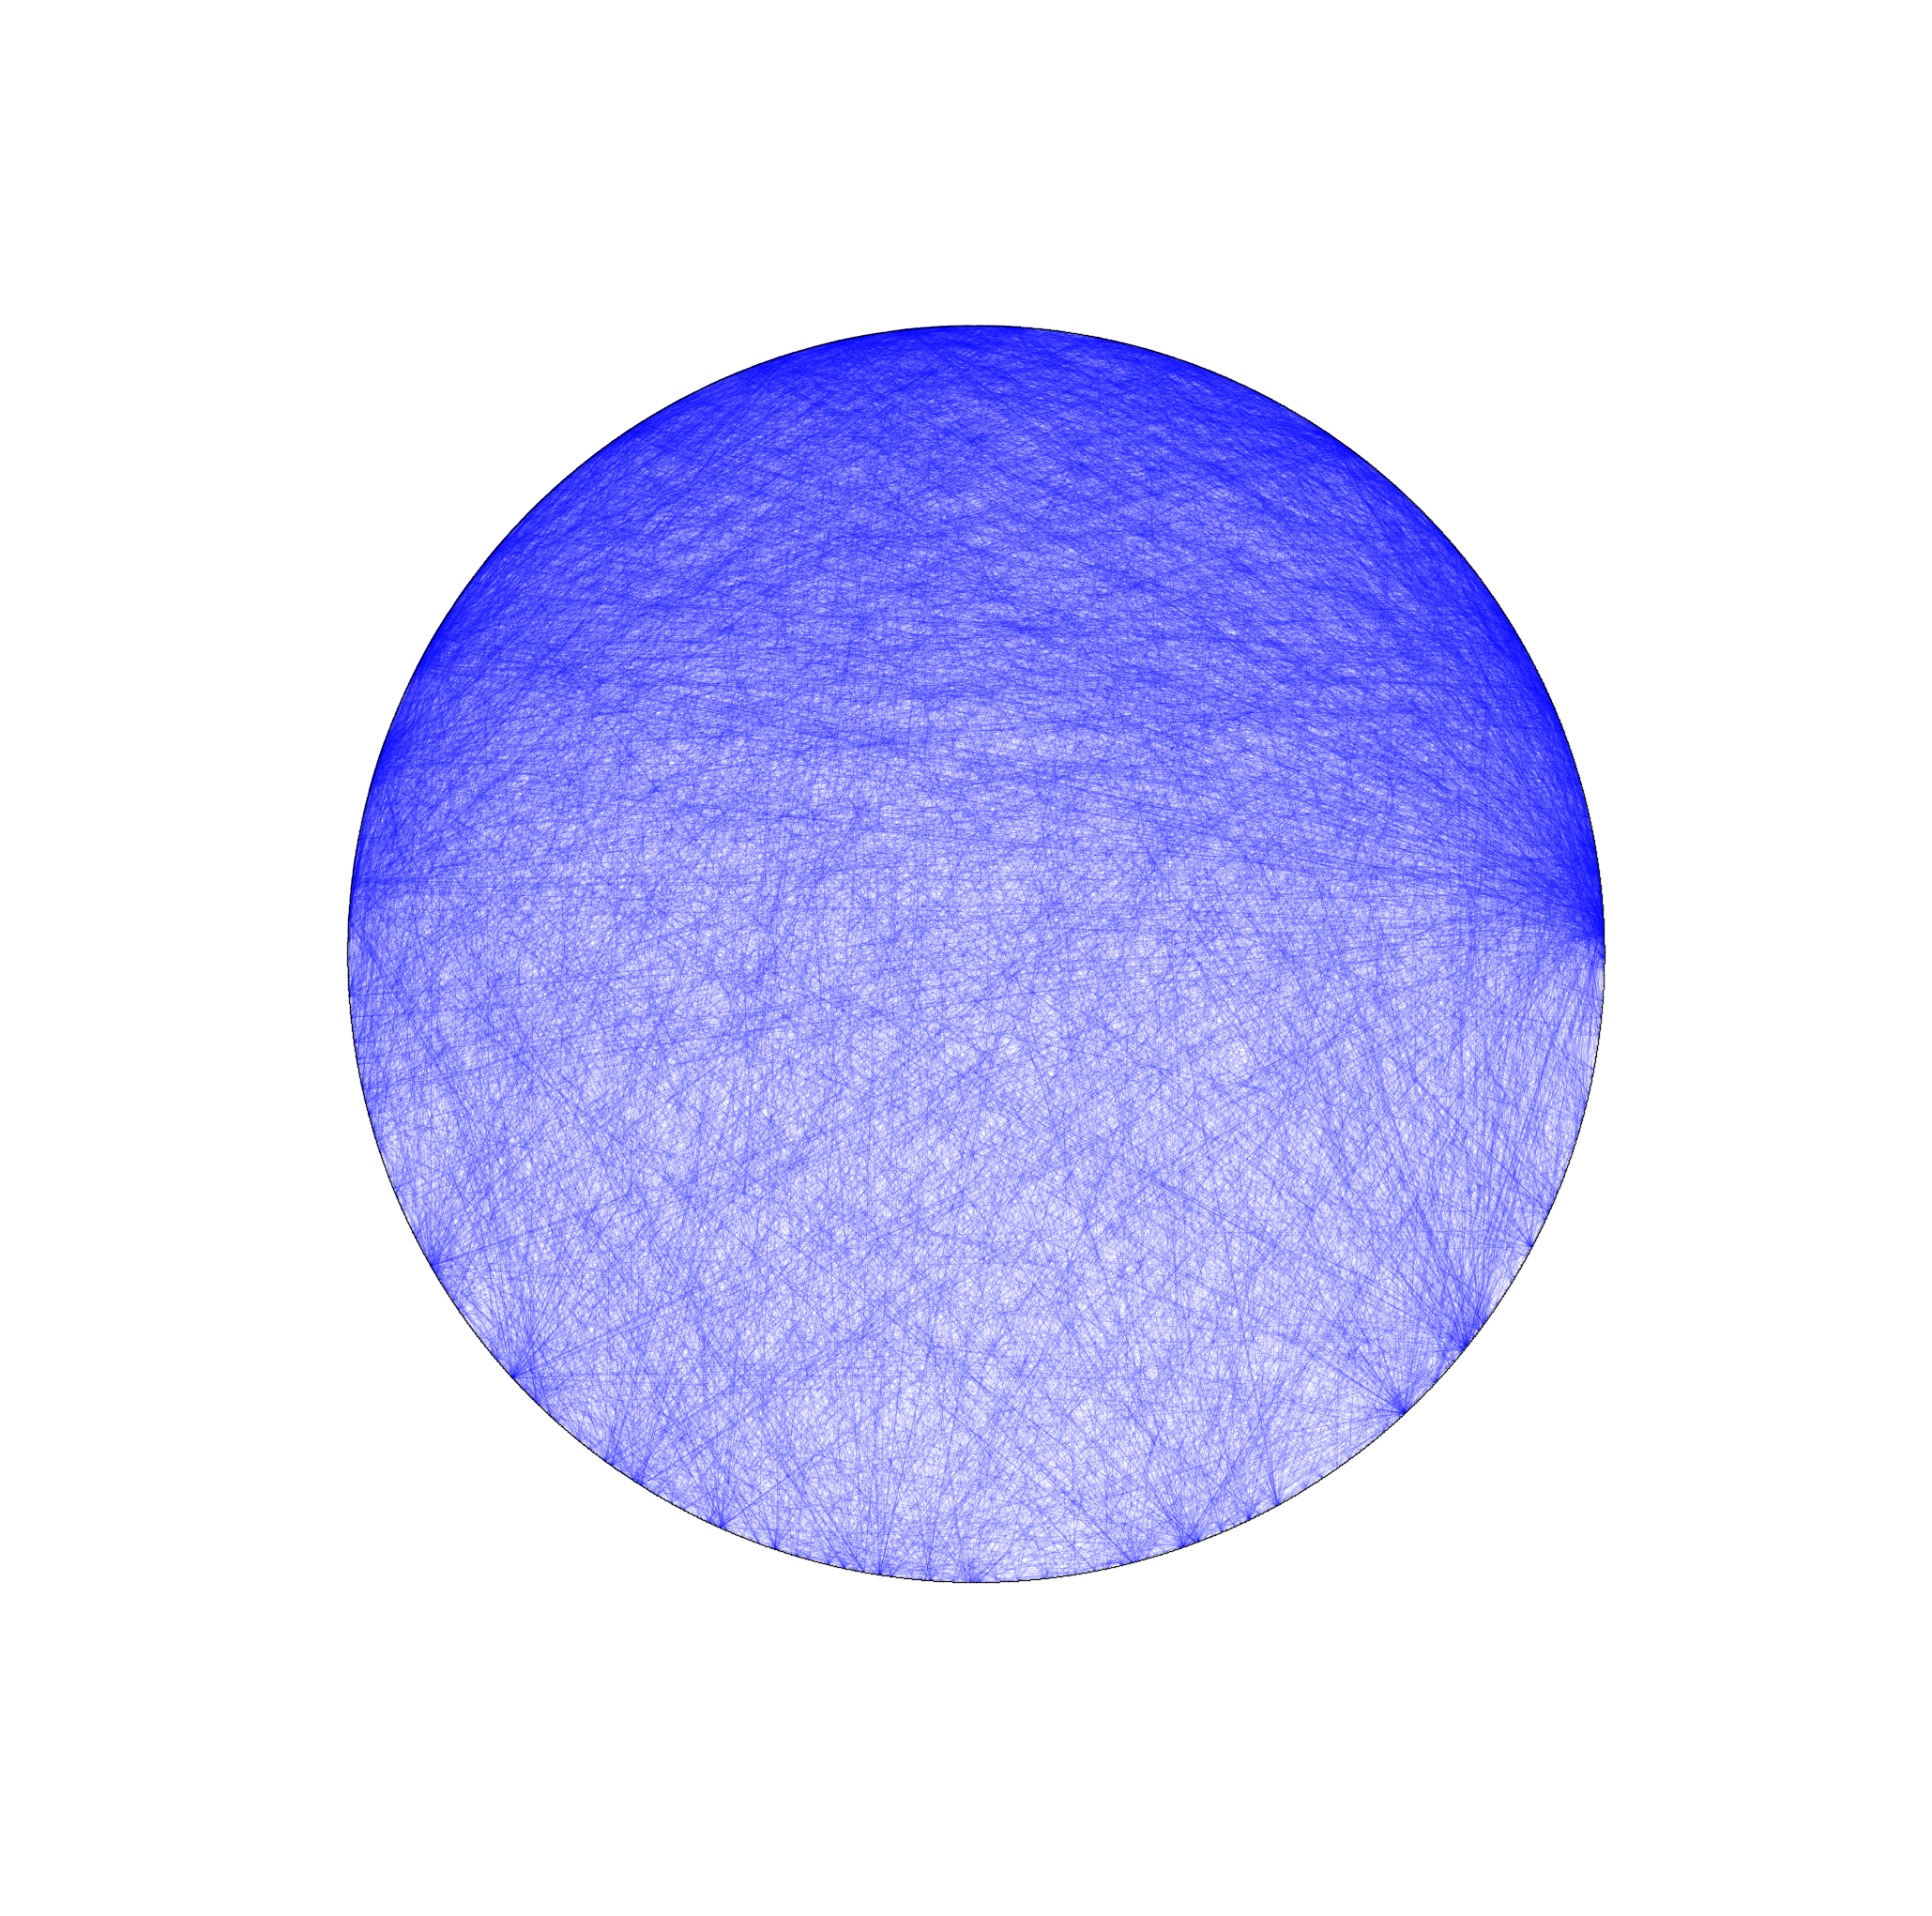

In [246]:
plt.figure(figsize=(36, 36))
train_graph = nx.Graph()
for ind, author in author_ind.iteritems():
    train_graph.add_node(ind)
for e in train_adj_list:
    train_graph.add_edge(e[0], e[1])
pos = nx.layout.circular_layout(train_graph)
edgewidths = 1.0
edgecolors = "blue"
nodesizes = 0.2

nx.draw_networkx_edges(train_graph, pos, width=edgewidths,
                                edge_color=edgecolors, alpha=0.1)

nx.draw_networkx_nodes(train_graph, pos, node_size=nodesizes,
                                linewidth=edgewidths,
                                node_color="black", alpha=1)

plt.axis('off')
plt.show()